# Breeden-Litzenberger Risk-Neutral Distribution Analysis


## Approach
1. Load closing option prices (matching SABR methodology)
2. Apply Breeden-Litzenberger formula: $q(K) = e^{rT} \frac{\partial^2 C}{\partial K^2}$
3. Two methods:
   - **Direct**: From market call prices (noisy but market-based)
   - **SABR-fitted**: From calibrated SABR prices (smooth, arbitrage-free)
4. Calculate tail metrics: skewness, kurtosis, tail probabilities
5. Compare Pre-Event (April 1) vs Post-Event (April 8)
6. Cross-validate with SABR rho findings

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries loaded")

✓ Libraries loaded


## 1. SABR Model Functions 
- take from SABR model

In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    """Hagan's SABR implied volatility formula."""
    X = K
    # ATM case
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


def BlackScholesCall(S, K, r, sigma, T):
    """Black-Scholes call price."""
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

print("✓ SABR functions defined")

✓ SABR functions defined


## 2. Load Closing Option Prices

Using the **exact same methodology** as SABR calibration:
- Closing prices (last row of intraday data)
- Mid prices = (bid + ask) / 2
- Same strikes, same expiries

In [3]:
def load_closing_call_prices(date, expiry, session='RTH', r=0.0014):
    """Load closing call prices for BL analysis."""
    base_path = Path(session)

    # Load files
    call_bid = pd.read_csv(base_path / f'{date}_call_bid_{expiry}.csv', index_col=0)
    call_ask = pd.read_csv(base_path / f'{date}_call_ask_{expiry}.csv', index_col=0)
    assets = pd.read_csv(base_path / f'{date}_assets.csv')

    # Get closing prices (last row)
    call_bid_close = call_bid.iloc[-1].replace(-1.0, np.nan)
    call_ask_close = call_ask.iloc[-1].replace(-1.0, np.nan)

    # Calculate mids
    call_mid = (call_bid_close + call_ask_close) / 2

    # Get strikes from column names (they're already strings like '4600.0')
    strike_strings = call_bid.columns.tolist()

    # Get closing spot
    S = assets['SPX'].iloc[-1]
    
    # Time to maturity
    trade_date = pd.to_datetime(date)
    expiry_date = pd.to_datetime(expiry, format='%Y%m%d')
    T = (expiry_date - trade_date).days / 365.25
    
    # Forward price
    F = S * np.exp(r * T)

    # Filter valid prices
    valid_data = []
    for strike_str in strike_strings:
        # Convert string to float for numerical strike value
        strike = float(strike_str)
        
        # Get price from Series using the original string key
        if strike_str in call_mid.index:
            price = call_mid[strike_str]
            if pd.notna(price) and price > 0:
                valid_data.append({
                    'strike': strike,
                    'call_price': price
                })

    # Create DataFrame with explicit columns to avoid KeyError
    if len(valid_data) == 0:
        # Return empty DataFrame with correct structure
        return pd.DataFrame(columns=['strike', 'call_price', 'spot', 'forward', 'T', 'moneyness'])

    df = pd.DataFrame(valid_data)
    df['spot'] = S
    df['forward'] = F
    df['T'] = T
    df['moneyness'] = df['strike'] / S

    return df

print("✓ Data loading function defined")

✓ Data loading function defined


## 3. Breeden-Litzenberger Formula Implementation

### Mathematical Foundation

The Breeden-Litzenberger formula states:

$$q(K) = e^{rT} \frac{\partial^2 C(K)}{\partial K^2}$$

where:
- $q(K)$ = risk-neutral probability density at strike $K$
- $C(K)$ = call option price at strike $K$
- $r$ = risk-free rate
- $T$ = time to expiry

### Numerical Implementation
For discrete strikes with unequal spacing, we use:

$$\frac{\partial^2 C}{\partial K^2} \approx \frac{2}{h_1 + h_2} \left[ \frac{C_{i+1} - C_i}{h_2} - \frac{C_i - C_{i-1}}{h_1} \right]$$

where $h_1 = K_i - K_{i-1}$ and $h_2 = K_{i+1} - K_i$

In [4]:
def calculate_rnd_direct(strikes, call_prices, r, T):
    """
    Calculate risk-neutral density using direct finite differences.
    
    Parameters:
    -----------
    strikes : array
        Strike prices (must be sorted)
    call_prices : array
        Call option prices at each strike
    r : float
        Risk-free rate
    T : float
        Time to expiry
        
    Returns:
    --------
    K_density : array
        Strikes where density is computed
    density : array
        Risk-neutral probability density
    """
    # Sort by strike
    sorted_idx = np.argsort(strikes)
    K = strikes[sorted_idx]
    C = call_prices[sorted_idx]
    
    if len(K) < 3:
        return None, None
    
    # Calculate second derivative using finite differences
    K_density = []
    density = []
    
    for i in range(1, len(K) - 1):
        K_minus = K[i-1]
        K_i = K[i]
        K_plus = K[i+1]
        
        C_minus = C[i-1]
        C_i = C[i]
        C_plus = C[i+1]
        
        h1 = K_i - K_minus
        h2 = K_plus - K_i
        
        if h1 > 0 and h2 > 0:
            # Second derivative with unequal spacing
            second_deriv = (2 / (h1 + h2)) * ((C_plus - C_i) / h2 - (C_i - C_minus) / h1)
            
            # Breeden-Litzenberger formula
            q = np.exp(r * T) * second_deriv
            
            # Only keep positive densities (negatives are numerical noise)
            if q > 0:
                K_density.append(K_i)
                density.append(q)
    
    if len(K_density) == 0:
        return None, None
    
    return np.array(K_density), np.array(density)


def calculate_rnd_smoothed(strikes, call_prices, r, T, num_points=100):
    """
    Calculate RND using smoothed call prices (PCHIP interpolation).
    This reduces noise but may miss sharp features.
    """
    # Sort by strike
    sorted_idx = np.argsort(strikes)
    K = strikes[sorted_idx]
    C = call_prices[sorted_idx]
    
    if len(K) < 5:
        return None, None
    
    # Remove duplicates
    unique_idx = np.unique(K, return_index=True)[1]
    K = K[np.sort(unique_idx)]
    C = C[np.sort(unique_idx)]
    
    if len(K) < 5:
        return None, None
    
    # Interpolate using shape-preserving PCHIP
    try:
        interp = PchipInterpolator(K, C, extrapolate=False)
    except:
        return None, None
    
    # Create fine grid
    K_min, K_max = float(K[0]), float(K[-1])
    K_grid = np.linspace(K_min, K_max, num_points)
    C_grid = interp(K_grid)
    
    # Handle NaNs
    mask = np.isfinite(C_grid)
    if not mask.all():
        C_grid = np.interp(K_grid, K_grid[mask], C_grid[mask])
    
    # Second derivative on uniform grid
    h = K_grid[1] - K_grid[0]
    C_pp = np.zeros_like(C_grid)
    
    # Central differences for interior
    C_pp[1:-1] = (C_grid[2:] - 2*C_grid[1:-1] + C_grid[:-2]) / (h**2)
    
    # One-sided for edges
    C_pp[0] = C_pp[1]
    C_pp[-1] = C_pp[-2]
    
    # Apply BL formula
    density = np.exp(r * T) * C_pp
    density = np.maximum(density, 0)  # Clip negatives
    
    # Normalize
    area = np.trapz(density, K_grid)
    if area > 0:
        density = density / area
    
    return K_grid, density

print("✓ BL formula functions defined")

✓ BL formula functions defined


## 4. SABR-Based RND (Cross-Validation)

Generate call prices from calibrated SABR parameters, then apply BL formula.
Provides a **smooth** RND for comparison.

In [5]:
def calculate_rnd_from_sabr(sabr_params, F, T, S, r, K_grid=None):
    """
    Calculate RND from SABR-fitted call prices.
    
    Parameters:
    -----------
    sabr_params : dict
        Dictionary with keys: alpha, beta, rho, nu
    F : float
        Forward price
    T : float
        Time to expiry
    S : float
        Spot price
    r : float
        Risk-free rate
    K_grid : array, optional
        Strike grid to evaluate (default: 0.8*S to 1.2*S)
    """
    if K_grid is None:
        K_grid = np.linspace(0.8 * S, 1.2 * S, 100)
    
    # Get SABR parameters
    alpha = sabr_params['alpha']
    beta = sabr_params['beta']
    rho = sabr_params['rho']
    nu = sabr_params['nu']
    
    # Calculate SABR implied vols
    sabr_ivs = np.array([SABR(F, K, T, alpha, beta, rho, nu) for K in K_grid])
    
    # Price calls using Black-Scholes with SABR IVs
    call_prices = np.array([BlackScholesCall(S, K, r, iv, T) 
                           for K, iv in zip(K_grid, sabr_ivs)])
    
    # Apply BL formula
    K_density, density = calculate_rnd_smoothed(K_grid, call_prices, r, T, num_points=100)
    
    return K_density, density

print("✓ SABR-based RND function defined")

✓ SABR-based RND function defined


## 5. Tail Metrics Calculation

Quantify the "fat left tail" with specific metrics:
- **Skewness**: Asymmetry of distribution (negative = left-skewed)
- **Kurtosis**: Tail heaviness (excess kurtosis > 0 = fat tails)
- **Tail probabilities**: P(S < threshold)
- **Left-tail mass**: Integrated probability in OTM put region

In [6]:
def calculate_tail_metrics(K, q, S):
    """
    Calculate distribution moments and tail probabilities.
    
    Parameters:
    -----------
    K : array
        Strike prices
    q : array
        Risk-neutral density
    S : float
        Current spot price
        
    Returns:
    --------
    metrics : dict
        Dictionary of tail metrics
    """
    # Normalize density
    area = np.trapz(q, K)
    if area > 0:
        q_norm = q / area
    else:
        return None
    
    # Calculate moments
    # Mean
    mean = np.trapz(K * q_norm, K)
    
    # Variance
    variance = np.trapz((K - mean)**2 * q_norm, K)
    std = np.sqrt(variance)
    
    # Skewness (third standardized moment)
    skewness = np.trapz((K - mean)**3 * q_norm, K) / (std**3)
    
    # Kurtosis (fourth standardized moment)
    kurtosis = np.trapz((K - mean)**4 * q_norm, K) / (std**4)
    excess_kurtosis = kurtosis - 3  # Excess over normal distribution
    
    # Tail probabilities
    # P(S < 0.95*S₀)
    threshold_95 = 0.95 * S
    mask_95 = K < threshold_95
    if mask_95.any():
        prob_95 = np.trapz(q_norm[mask_95], K[mask_95])
    else:
        prob_95 = 0.0
    
    # P(S < 0.90*S₀)
    threshold_90 = 0.90 * S
    mask_90 = K < threshold_90
    if mask_90.any():
        prob_90 = np.trapz(q_norm[mask_90], K[mask_90])
    else:
        prob_90 = 0.0
    
    # P(S < 0.85*S₀)
    threshold_85 = 0.85 * S
    mask_85 = K < threshold_85
    if mask_85.any():
        prob_85 = np.trapz(q_norm[mask_85], K[mask_85])
    else:
        prob_85 = 0.0
    
    # Left-tail mass (0.80 to 0.95 of spot)
    mask_left = (K >= 0.80 * S) & (K <= 0.95 * S)
    if mask_left.any():
        left_tail_mass = np.trapz(q_norm[mask_left], K[mask_left])
    else:
        left_tail_mass = 0.0
    
    return {
        'mean': mean,
        'std': std,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'excess_kurtosis': excess_kurtosis,
        'P(S < 0.95*S0)': prob_95,
        'P(S < 0.90*S0)': prob_90,
        'P(S < 0.85*S0)': prob_85,
        'left_tail_mass': left_tail_mass
    }

print("✓ Tail metrics function defined")

✓ Tail metrics function defined


## 6. Load SABR Calibration Results

In [7]:
# Load SABR results
sabr_df = pd.read_csv('sabr_calibration_results_RTH.csv')
print("SABR Calibration Results:")
print(sabr_df[['date', 'expiry', 'spot', 'alpha', 'rho', 'nu', 'rmse']].to_string())

# Create SABR parameter lookup
def get_sabr_params(date, expiry):
    """Get SABR parameters for a given date and expiry."""
    row = sabr_df[(sabr_df['date'] == date) & (sabr_df['expiry'] == int(expiry))]
    if row.empty:
        return None
    return {
        'alpha': row['alpha'].iloc[0],
        'beta': row['beta'].iloc[0],
        'rho': row['rho'].iloc[0],
        'nu': row['nu'].iloc[0]
    }

print("\n✓ SABR results loaded")

SABR Calibration Results:
         date    expiry     spot     alpha       rho        nu      rmse
0  2025-04-01  20250416  5633.07  2.515818 -0.605277  3.660155  0.000806
1  2025-04-02  20250416  5670.97  2.398775 -0.534496  3.814583  0.003437
2  2025-04-03  20250416  5396.52  3.499764 -0.591286  4.200972  0.001552
3  2025-04-04  20250416  5074.08  5.949912 -0.718079  4.461910  0.000833
4  2025-04-07  20250515  5062.25  4.693968 -0.703390  1.827703  0.001941
5  2025-04-08  20250515  4982.77  5.204044 -0.792889  2.291699  0.000357
6  2025-04-09  20250515  5456.90  3.373555 -0.715634  2.660686  0.000192
7  2025-04-10  20250515  5268.05  4.368527 -0.796635  2.229235  0.000917

✓ SABR results loaded


## 7. Extract RNDs for ALL Dates (Full Time Series)

Compare:
- **April 1, 2025** (Pre-Event)
- **April 2, 2025** (Liberation Day)
- **April 3-4, 2025** (Event Period)
- **April 7-10, 2025** (Post-Event)

In [8]:
# Parameters
r = 0.0014

# ALL 8 DATES (not just 2!)
dates = [
    '2025-04-01',  # Pre-Event
    '2025-04-02',  # Liberation Day
    '2025-04-03',  # Event
    '2025-04-04',  # Event
    '2025-04-07',  # Post-Event
    '2025-04-08',  # Post-Event
    '2025-04-09',  # Post-Event
    '2025-04-10'   # Post-Event
]
expiries = ['20250416', '20250515']

results = {}

for date in dates:
    # Determine expiry for this date
    expiry = expiries[0] if date <= '2025-04-04' else expiries[1]

    print(f"\n{'='*80}")
    print(f"Processing {date} → {expiry}")
    print(f"{'='*80}")

    # Load market data
    market_data = load_closing_call_prices(date, expiry, session='RTH', r=r)

    if len(market_data) == 0:
        print(f"✗ No valid call prices found for {date}")
        continue

    print(f"✓ Loaded {len(market_data)} valid call prices")
    print(f"  Spot: {market_data['spot'].iloc[0]:.2f}")
    print(f"  Forward: {market_data['forward'].iloc[0]:.2f}")
    print(f"  T: {market_data['T'].iloc[0]:.4f} years")

    S = market_data['spot'].iloc[0]
    F = market_data['forward'].iloc[0]
    T = market_data['T'].iloc[0]

    # Method 1: Direct from market prices
    K_direct, q_direct = calculate_rnd_direct(
        market_data['strike'].values,
        market_data['call_price'].values,
        r, T
    )

    # Method 2: Smoothed market prices
    K_smooth, q_smooth = calculate_rnd_smoothed(
        market_data['strike'].values,
        market_data['call_price'].values,
        r, T
    )

    # Method 3: SABR-fitted prices
    sabr_params = get_sabr_params(date, expiry)
    if sabr_params:
        K_sabr, q_sabr = calculate_rnd_from_sabr(sabr_params, F, T, S, r)
        print(f"  SABR params: α={sabr_params['alpha']:.4f}, ρ={sabr_params['rho']:.4f}, ν={sabr_params['nu']:.4f}")
    else:
        K_sabr, q_sabr = None, None
        print("  ⚠️ No SABR parameters found")

    # Calculate tail metrics for each method
    metrics_direct = calculate_tail_metrics(K_direct, q_direct, S) if K_direct is not None else None
    metrics_smooth = calculate_tail_metrics(K_smooth, q_smooth, S) if K_smooth is not None else None
    metrics_sabr = calculate_tail_metrics(K_sabr, q_sabr, S) if K_sabr is not None else None

    # Store results
    results[date] = {
        'market_data': market_data,
        'spot': S,
        'forward': F,
        'T': T,
        'direct': {'K': K_direct, 'q': q_direct, 'metrics': metrics_direct},
        'smooth': {'K': K_smooth, 'q': q_smooth, 'metrics': metrics_smooth},
        'sabr': {'K': K_sabr, 'q': q_sabr, 'metrics': metrics_sabr, 'params': sabr_params}
    }

    # Print key metrics (SABR only for brevity)
    if metrics_sabr:
        print(f"  Key Metrics:")
        print(f"    Skewness: {metrics_sabr['skewness']:.4f}")
        print(f"    P(S<0.90S₀): {metrics_sabr['P(S < 0.90*S0)']:.4f}")
        print(f"    Tail mass: {metrics_sabr['left_tail_mass']:.4f}")

print("\n" + "="*80)
print(f"✓ RND extraction complete for {len(results)} dates")
print("="*80)


Processing 2025-04-01 → 20250416
✓ Loaded 74 valid call prices
  Spot: 5633.07
  Forward: 5633.39
  T: 0.0411 years
  SABR params: α=2.5158, ρ=-0.6053, ν=3.6602
  Key Metrics:
    Skewness: -1.0802
    P(S<0.90S₀): 0.0238
    Tail mass: 0.0978

Processing 2025-04-02 → 20250416
✓ Loaded 68 valid call prices
  Spot: 5670.97
  Forward: 5671.27
  T: 0.0383 years
  SABR params: α=2.3988, ρ=-0.5345, ν=3.8146
  Key Metrics:
    Skewness: -1.0217
    P(S<0.90S₀): 0.0192
    Tail mass: 0.0872

Processing 2025-04-03 → 20250416
✓ Loaded 81 valid call prices
  Spot: 5396.52
  Forward: 5396.79
  T: 0.0356 years
  SABR params: α=3.4998, ρ=-0.5913, ν=4.2010
  Key Metrics:
    Skewness: -0.8213
    P(S<0.90S₀): 0.0400
    Tail mass: 0.1300

Processing 2025-04-04 → 20250416
✓ Loaded 73 valid call prices
  Spot: 5074.08
  Forward: 5074.31
  T: 0.0329 years
  SABR params: α=5.9499, ρ=-0.7181, ν=4.4619
  Key Metrics:
    Skewness: -0.6059
    P(S<0.90S₀): 0.0746
    Tail mass: 0.1768

Processing 2025-04-

## 8. Visualize RND Evolution

### Plot 1: PDF Comparison (Pre vs Post Event)

✓ Saved: rnd_pdf_comparison_full_series.png (8-date evolution)


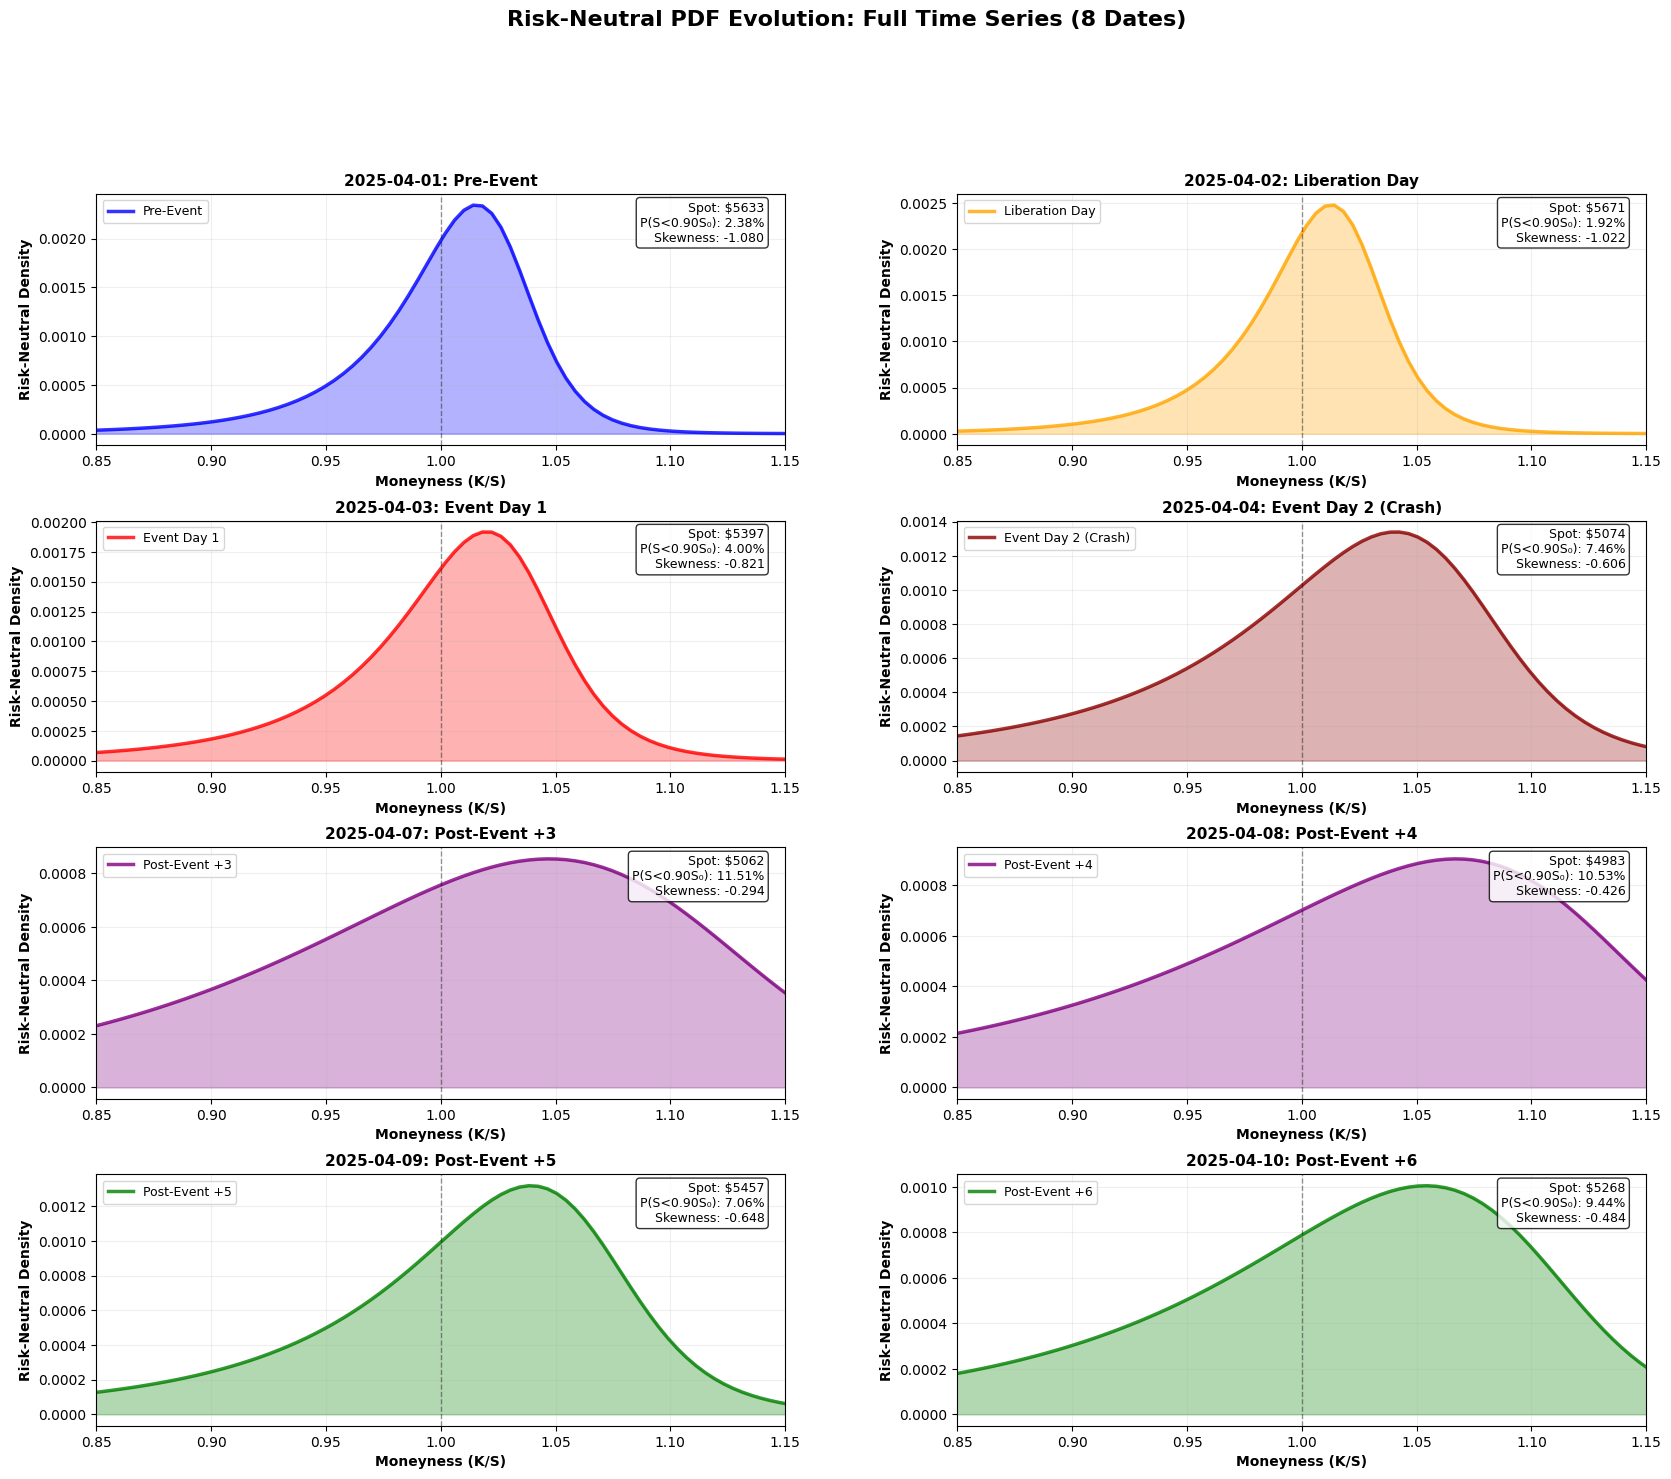

✓ Saved: rnd_pdf_comparison.png (2-date comparison for reference)


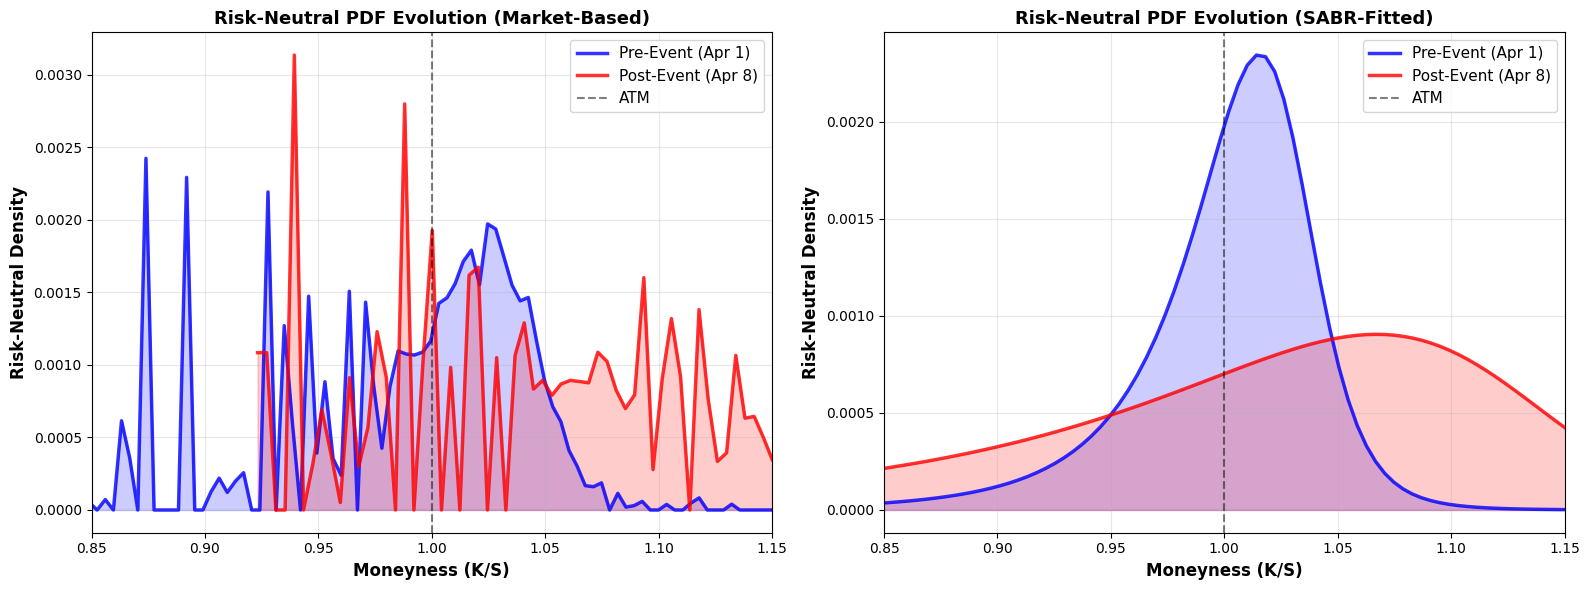

In [9]:
# Create 8-panel visualization showing PDF evolution across ALL dates
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Prepare data: all 8 dates sorted chronologically
all_dates = sorted(results.keys())
lib_day_str = '2025-04-02'

# Create figure with 4x2 grid (8 subplots)
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 2, figure=fig, hspace=0.3, wspace=0.25)

# Define colors based on period
color_map = {
    '2025-04-01': 'blue',       # Pre-Event
    '2025-04-02': 'orange',      # Liberation Day
    '2025-04-03': 'red',         # Event
    '2025-04-04': 'darkred',     # Event (crash)
    '2025-04-07': 'purple',      # Post-Event
    '2025-04-08': 'purple',      # Post-Event
    '2025-04-09': 'green',       # Post-Event
    '2025-04-10': 'green'        # Post-Event
}

period_labels = {
    '2025-04-01': 'Pre-Event',
    '2025-04-02': 'Liberation Day',
    '2025-04-03': 'Event Day 1',
    '2025-04-04': 'Event Day 2 (Crash)',
    '2025-04-07': 'Post-Event +3',
    '2025-04-08': 'Post-Event +4',
    '2025-04-09': 'Post-Event +5',
    '2025-04-10': 'Post-Event +6'
}

# Plot each date in its own panel
for idx, date in enumerate(all_dates):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])
    
    if date in results and results[date]['sabr']['K'] is not None:
        K = results[date]['sabr']['K']
        q = results[date]['sabr']['q']
        S = results[date]['spot']
        
        # Convert to moneyness
        m = K / S
        
        # Get color and label
        color = color_map.get(date, 'gray')
        label = period_labels.get(date, date)
        
        # Plot PDF
        ax.plot(m, q, linewidth=2.5, color=color, alpha=0.8, label=f'{label}')
        ax.fill_between(m, 0, q, alpha=0.3, color=color)
        
        # Reference line at ATM
        ax.axvline(1.0, color='black', linestyle='--', alpha=0.4, linewidth=1)
        
        # Get metrics for annotation
        metrics = results[date]['sabr']['metrics']
        if metrics:
            tail_prob = metrics['P(S < 0.90*S0)'] * 100
            skewness = metrics['skewness']
            
            # Add metrics text box
            textstr = f"Spot: ${S:.0f}\n"
            textstr += f"P(S<0.90S₀): {tail_prob:.2f}%\n"
            textstr += f"Skewness: {skewness:.3f}"
            
            ax.text(0.97, 0.97, textstr, transform=ax.transAxes,
                   fontsize=9, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Formatting
        ax.set_xlabel('Moneyness (K/S)', fontsize=10, fontweight='bold')
        ax.set_ylabel('Risk-Neutral Density', fontsize=10, fontweight='bold')
        ax.set_title(f'{date}: {label}', fontsize=11, fontweight='bold')
        ax.set_xlim(0.85, 1.15)
        ax.grid(True, alpha=0.2)
        ax.legend(fontsize=9, loc='upper left')

# Overall title
fig.suptitle('Risk-Neutral PDF Evolution: Full Time Series (8 Dates)', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig('rnd_pdf_comparison_full_series.png', dpi=150, bbox_inches='tight')
print("✓ Saved: rnd_pdf_comparison_full_series.png (8-date evolution)")
plt.show()

# Also create the original 2-date comparison for backward compatibility
fig2, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Direct comparison using market smoothed
ax1 = axes[0]
for date, label, color in [('2025-04-01', 'Pre-Event (Apr 1)', 'blue'),
                            ('2025-04-08', 'Post-Event (Apr 8)', 'red')]:
    if date in results and results[date]['smooth']['K'] is not None:
        K = results[date]['smooth']['K']
        q = results[date]['smooth']['q']
        S = results[date]['spot']
        
        # Convert to moneyness
        m = K / S
        
        ax1.plot(m, q, linewidth=2.5, label=label, color=color, alpha=0.8)
        ax1.fill_between(m, 0, q, alpha=0.2, color=color)

ax1.axvline(1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
ax1.set_xlabel('Moneyness (K/S)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Risk-Neutral Density', fontsize=12, fontweight='bold')
ax1.set_title('Risk-Neutral PDF Evolution (Market-Based)', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0.85, 1.15)

# Plot 2: SABR-fitted comparison
ax2 = axes[1]
for date, label, color in [('2025-04-01', 'Pre-Event (Apr 1)', 'blue'),
                            ('2025-04-08', 'Post-Event (Apr 8)', 'red')]:
    if date in results and results[date]['sabr']['K'] is not None:
        K = results[date]['sabr']['K']
        q = results[date]['sabr']['q']
        S = results[date]['spot']
        
        # Convert to moneyness
        m = K / S
        
        ax2.plot(m, q, linewidth=2.5, label=label, color=color, alpha=0.8)
        ax2.fill_between(m, 0, q, alpha=0.2, color=color)

ax2.axvline(1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
ax2.set_xlabel('Moneyness (K/S)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Risk-Neutral Density', fontsize=12, fontweight='bold')
ax2.set_title('Risk-Neutral PDF Evolution (SABR-Fitted)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0.85, 1.15)

plt.tight_layout()
plt.savefig('rnd_pdf_comparison.png', dpi=150, bbox_inches='tight')
print("✓ Saved: rnd_pdf_comparison.png (2-date comparison for reference)")
plt.show()

## 9. Tail Probability Evolution

✓ Saved: rnd_tail_probabilities_full_series.png (8-date evolution)


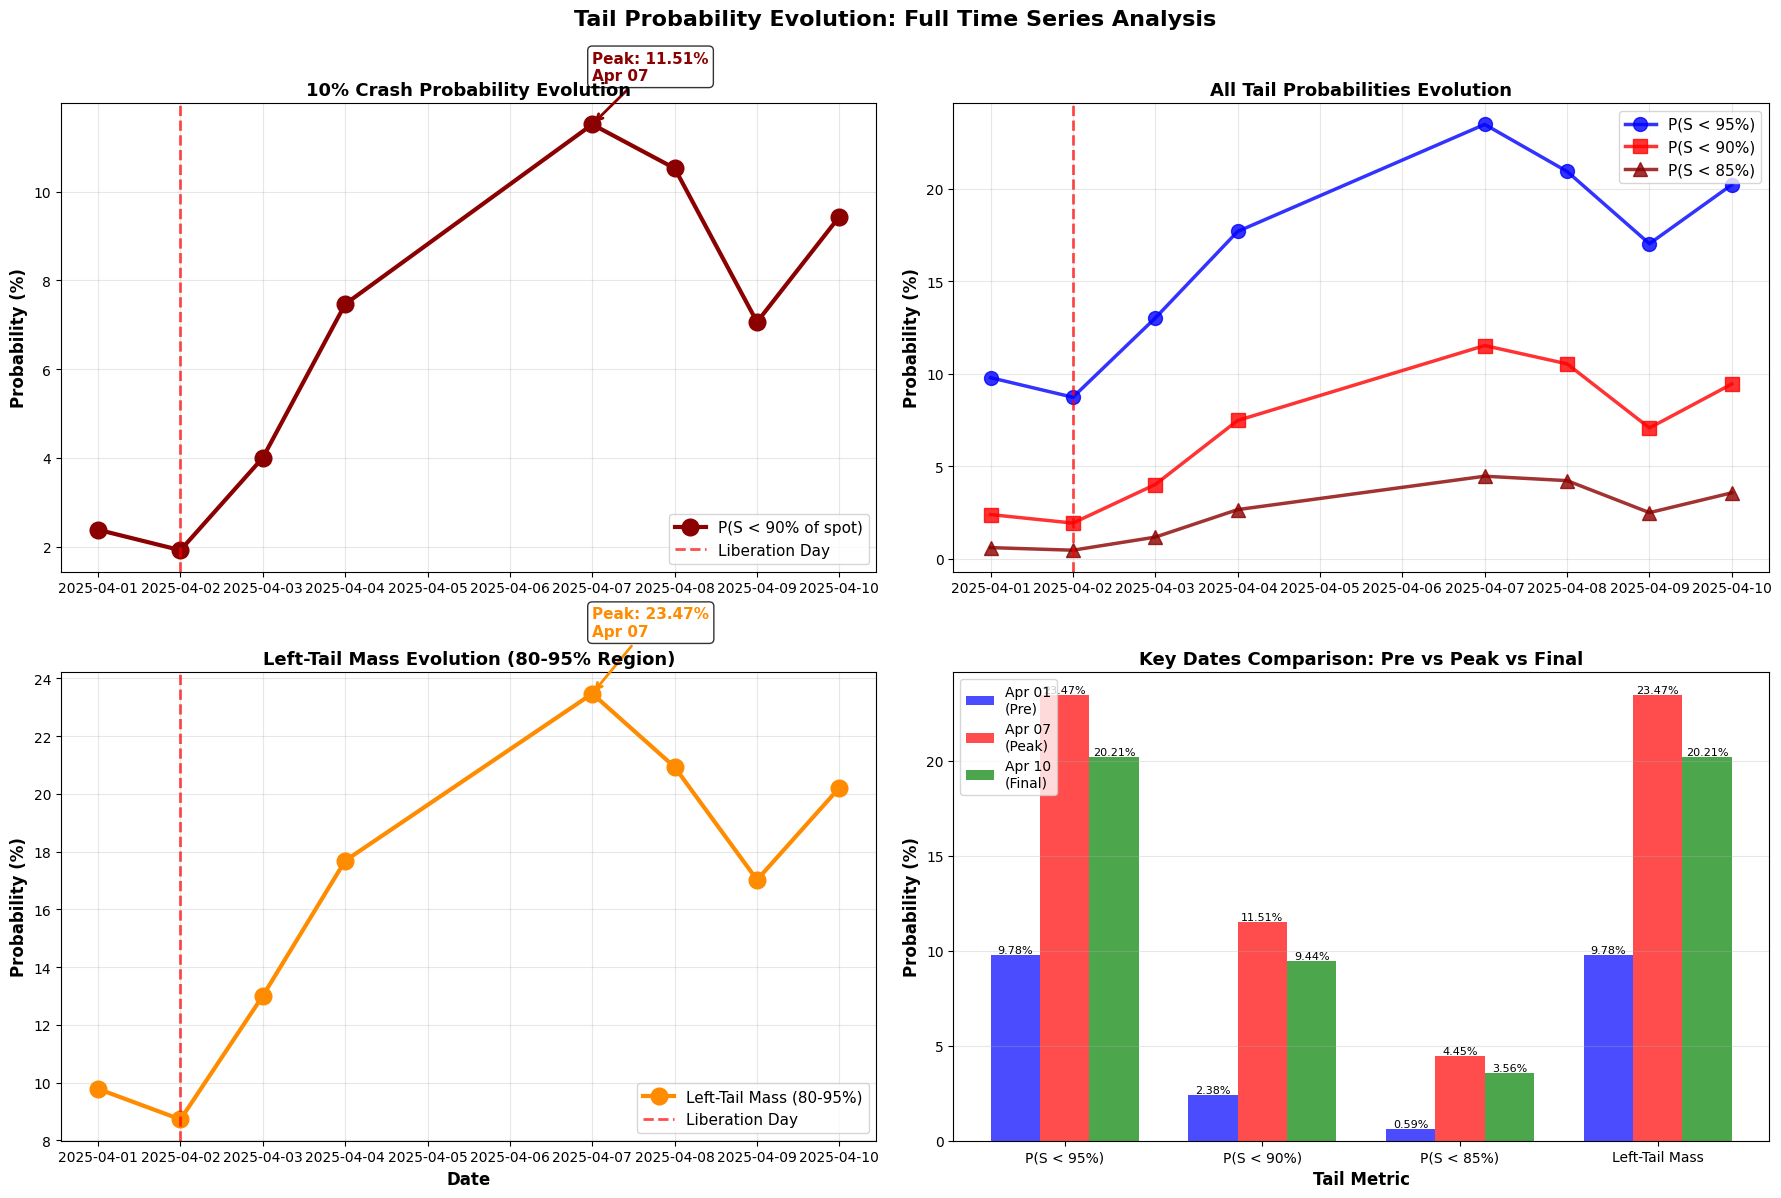

✓ Saved: rnd_tail_probabilities.png (2-date comparison for reference)


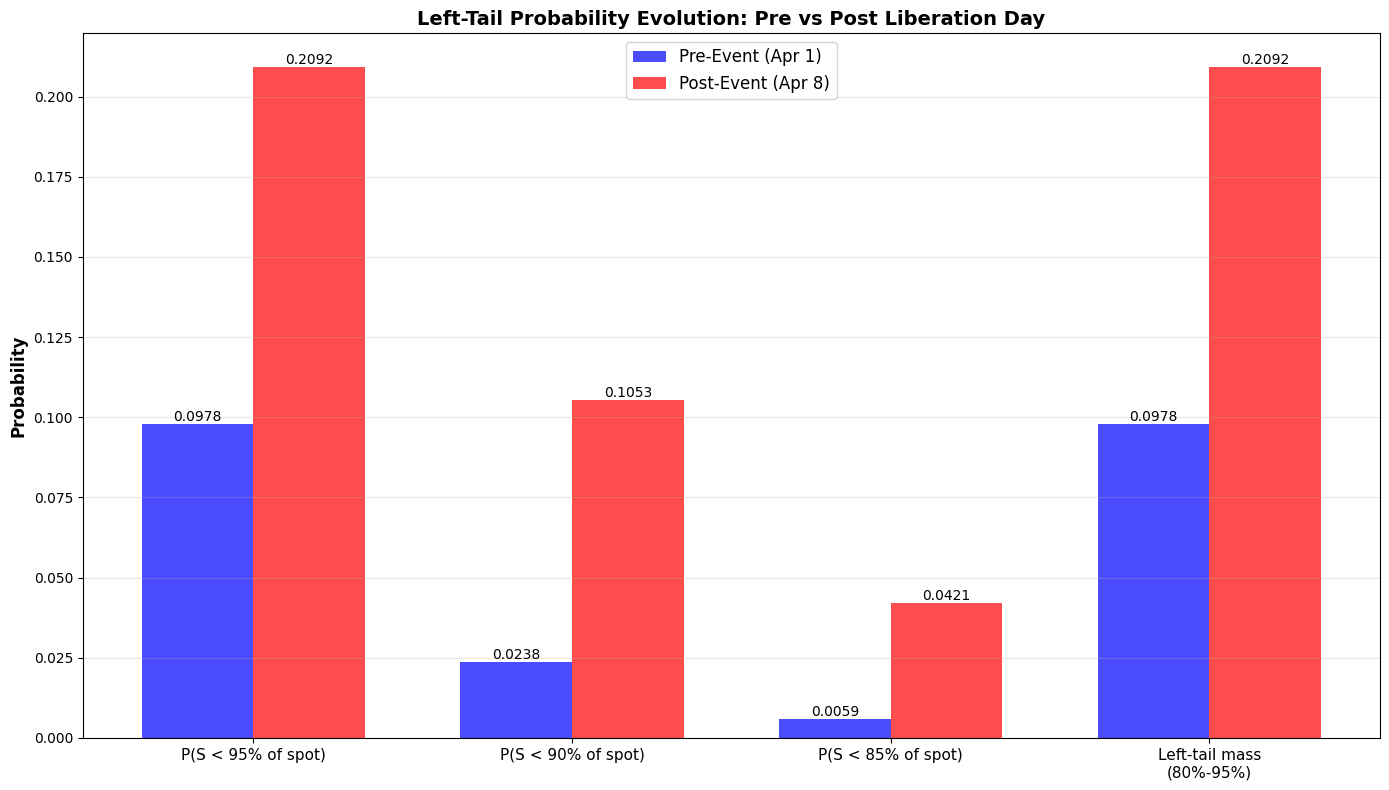


TAIL PROBABILITY EVOLUTION SUMMARY

Pre-Event (April 1):
  P(S < 0.90S₀): 2.38%
  Left-tail mass: 9.78%

PEAK (April 07):
  P(S < 0.90S₀): 11.51% ← MAXIMUM
  Left-tail mass: 23.47%

Crash Day (April 4):
  P(S < 0.90S₀): 7.46%
  Left-tail mass: 17.68%
  → 4.05pp HIGHER at peak than crash day!

Post-Event (April 8):
  P(S < 0.90S₀): 10.53%
  Left-tail mass: 20.92%

Final (April 10):
  P(S < 0.90S₀): 9.44%
  Left-tail mass: 20.21%


In [10]:
# Create comprehensive tail probability evolution visualization across ALL 8 dates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extract ALL dates and metrics from results
all_dates = sorted(results.keys())
tail_data = []

for date in all_dates:
    if date in results and results[date]['sabr']['metrics'] is not None:
        metrics = results[date]['sabr']['metrics']
        tail_data.append({
            'date': pd.to_datetime(date),
            'spot': results[date]['spot'],
            'prob_95': metrics['P(S < 0.95*S0)'] * 100,
            'prob_90': metrics['P(S < 0.90*S0)'] * 100,
            'prob_85': metrics['P(S < 0.85*S0)'] * 100,
            'left_tail_mass': metrics['left_tail_mass'] * 100
        })

tail_df = pd.DataFrame(tail_data)
lib_day = pd.to_datetime('2025-04-02')

# Create 2x2 panel visualization
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Panel 1: P(S < 0.90*S₀) Time Series
ax1 = axes[0, 0]
ax1.plot(tail_df['date'], tail_df['prob_90'], 'o-', linewidth=3, markersize=12,
         color='darkred', label='P(S < 90% of spot)')
ax1.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Liberation Day')

# Annotate peak
max_idx = tail_df['prob_90'].idxmax()
max_date = tail_df.loc[max_idx, 'date']
max_val = tail_df.loc[max_idx, 'prob_90']
ax1.annotate(f'Peak: {max_val:.2f}%\n{max_date.strftime("%b %d")}',
            xy=(max_date, max_val),
            xytext=(max_date, max_val + 1),
            fontsize=11, color='darkred', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='darkred', lw=2),
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax1.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax1.set_title('10% Crash Probability Evolution', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Panel 2: All Tail Probabilities Together
ax2 = axes[0, 1]
ax2.plot(tail_df['date'], tail_df['prob_95'], 'o-', linewidth=2.5, markersize=10,
         color='blue', label='P(S < 95%)', alpha=0.8)
ax2.plot(tail_df['date'], tail_df['prob_90'], 's-', linewidth=2.5, markersize=10,
         color='red', label='P(S < 90%)', alpha=0.8)
ax2.plot(tail_df['date'], tail_df['prob_85'], '^-', linewidth=2.5, markersize=10,
         color='darkred', label='P(S < 85%)', alpha=0.8)
ax2.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)

ax2.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax2.set_title('All Tail Probabilities Evolution', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Panel 3: Left-Tail Mass Evolution
ax3 = axes[1, 0]
ax3.plot(tail_df['date'], tail_df['left_tail_mass'], 'o-', linewidth=3, markersize=12,
         color='darkorange', label='Left-Tail Mass (80-95%)')
ax3.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Liberation Day')

# Annotate peak
max_idx = tail_df['left_tail_mass'].idxmax()
max_date = tail_df.loc[max_idx, 'date']
max_val = tail_df.loc[max_idx, 'left_tail_mass']
ax3.annotate(f'Peak: {max_val:.2f}%\n{max_date.strftime("%b %d")}',
            xy=(max_date, max_val),
            xytext=(max_date, max_val + 2),
            fontsize=11, color='darkorange', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='darkorange', lw=2),
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax3.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Date', fontsize=12, fontweight='bold')
ax3.set_title('Left-Tail Mass Evolution (80-95% Region)', fontsize=13, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)

# Panel 4: Bar Chart showing Pre vs Peak vs Final
ax4 = axes[1, 1]

# Select key dates for comparison
pre_date = tail_df.iloc[0]
peak_idx = tail_df['prob_90'].idxmax()
peak_date = tail_df.iloc[peak_idx]
final_date = tail_df.iloc[-1]

dates_to_compare = [pre_date['date'].strftime('%b %d\n(Pre)'),
                    peak_date['date'].strftime('%b %d\n(Peak)'),
                    final_date['date'].strftime('%b %d\n(Final)')]

metrics_to_plot = ['P(S < 95%)', 'P(S < 90%)', 'P(S < 85%)', 'Left-Tail Mass']
values_pre = [pre_date['prob_95'], pre_date['prob_90'], pre_date['prob_85'], pre_date['left_tail_mass']]
values_peak = [peak_date['prob_95'], peak_date['prob_90'], peak_date['prob_85'], peak_date['left_tail_mass']]
values_final = [final_date['prob_95'], final_date['prob_90'], final_date['prob_85'], final_date['left_tail_mass']]

x = np.arange(len(metrics_to_plot))
width = 0.25

bars1 = ax4.bar(x - width, values_pre, width, label=dates_to_compare[0], color='blue', alpha=0.7)
bars2 = ax4.bar(x, values_peak, width, label=dates_to_compare[1], color='red', alpha=0.7)
bars3 = ax4.bar(x + width, values_final, width, label=dates_to_compare[2], color='green', alpha=0.7)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=8)

ax4.set_ylabel('Probability (%)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Tail Metric', fontsize=12, fontweight='bold')
ax4.set_title('Key Dates Comparison: Pre vs Peak vs Final', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics_to_plot, fontsize=10)
ax4.legend(fontsize=10, loc='upper left')
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Tail Probability Evolution: Full Time Series Analysis', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('rnd_tail_probabilities_full_series.png', dpi=150, bbox_inches='tight')
print("✓ Saved: rnd_tail_probabilities_full_series.png (8-date evolution)")
plt.show()

# Also create original 2-date comparison for backward compatibility
pre_metrics = results['2025-04-01']['sabr']['metrics']
post_metrics = results['2025-04-08']['sabr']['metrics']

metrics_to_plot_orig = ['P(S < 0.95*S0)', 'P(S < 0.90*S0)', 'P(S < 0.85*S0)', 'left_tail_mass']
labels_orig = ['P(S < 95% of spot)', 'P(S < 90% of spot)', 'P(S < 85% of spot)', 'Left-tail mass\n(80%-95%)']

pre_values = [pre_metrics[m] for m in metrics_to_plot_orig]
post_values = [post_metrics[m] for m in metrics_to_plot_orig]

x = np.arange(len(labels_orig))
width = 0.35

fig2, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width/2, pre_values, width, label='Pre-Event (Apr 1)', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, post_values, width, label='Post-Event (Apr 8)', color='red', alpha=0.7)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}',
                ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Probability', fontsize=12, fontweight='bold')
ax.set_title('Left-Tail Probability Evolution: Pre vs Post Liberation Day', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels_orig, fontsize=11)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('rnd_tail_probabilities.png', dpi=150, bbox_inches='tight')
print("✓ Saved: rnd_tail_probabilities.png (2-date comparison for reference)")
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("TAIL PROBABILITY EVOLUTION SUMMARY")
print("="*80)
print(f"\nPre-Event (April 1):")
print(f"  P(S < 0.90S₀): {tail_df.iloc[0]['prob_90']:.2f}%")
print(f"  Left-tail mass: {tail_df.iloc[0]['left_tail_mass']:.2f}%")

print(f"\nPEAK ({peak_date['date'].strftime('%B %d')}):")
print(f"  P(S < 0.90S₀): {peak_date['prob_90']:.2f}% ← MAXIMUM")
print(f"  Left-tail mass: {peak_date['left_tail_mass']:.2f}%")

print(f"\nCrash Day (April 4):")
crash_row = tail_df[tail_df['date'] == '2025-04-04']
if not crash_row.empty:
    print(f"  P(S < 0.90S₀): {crash_row.iloc[0]['prob_90']:.2f}%")
    print(f"  Left-tail mass: {crash_row.iloc[0]['left_tail_mass']:.2f}%")
    print(f"  → {peak_date['prob_90'] - crash_row.iloc[0]['prob_90']:.2f}pp HIGHER at peak than crash day!")

print(f"\nPost-Event (April 8):")
print(f"  P(S < 0.90S₀): {tail_df.iloc[5]['prob_90']:.2f}%")
print(f"  Left-tail mass: {tail_df.iloc[5]['left_tail_mass']:.2f}%")

print(f"\nFinal (April 10):")
print(f"  P(S < 0.90S₀): {tail_df.iloc[-1]['prob_90']:.2f}%")
print(f"  Left-tail mass: {tail_df.iloc[-1]['left_tail_mass']:.2f}%")
print("="*80)

## 10. Cross-Validation: SABR Rho vs BL Skewness

- **SABR rho**: More negative = stronger left skew
- **BL skewness**: More negative = left-skewed distribution



CROSS-VALIDATION: SABR Rho vs BL Skewness
      date  SABR_rho  BL_skewness
2025-04-01 -0.605277    -1.080165
2025-04-08 -0.792889    -0.426124

Changes (Post - Pre):
  SABR rho change: -0.1876
  BL skewness change: +0.6540

⚠️ PARTIAL VALIDATION: One metric shows left skew strengthening

✓ Saved: sabr_vs_bl_validation.png


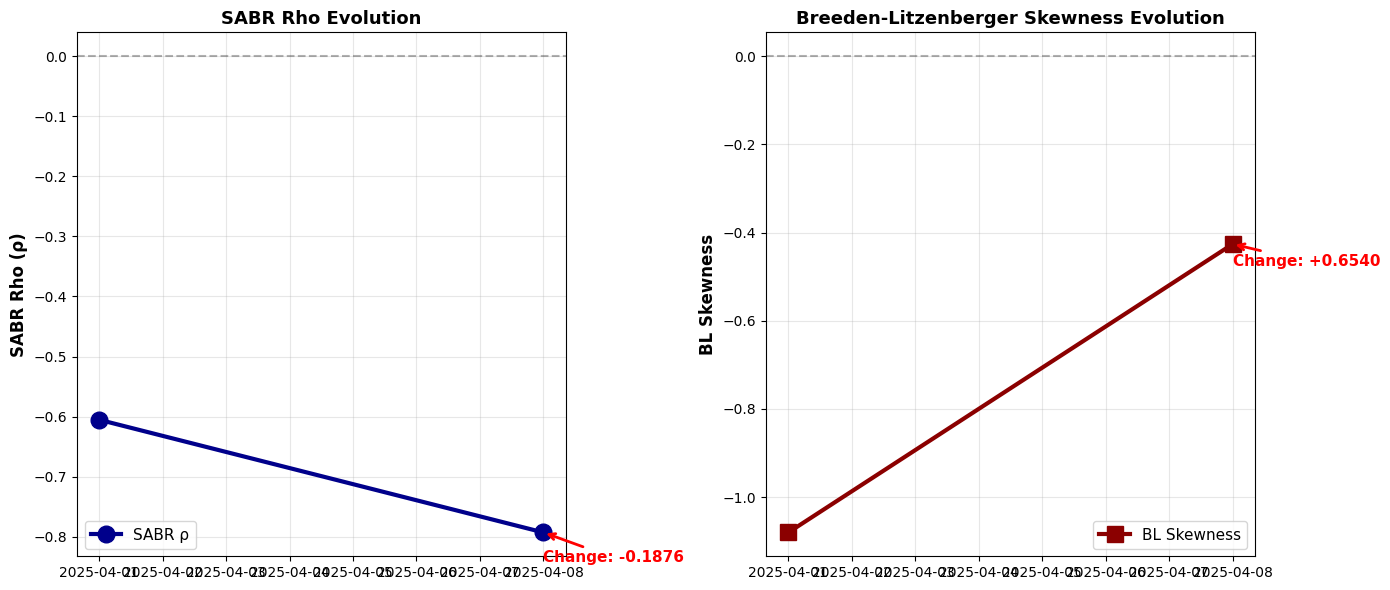

In [11]:
# Collect all SABR rho and BL skewness values
comparison_data = []

for date in ['2025-04-01', '2025-04-08']:
    if date in results:
        sabr_rho = results[date]['sabr']['params']['rho']
        bl_skewness = results[date]['sabr']['metrics']['skewness']
        
        comparison_data.append({
            'date': date,
            'SABR_rho': sabr_rho,
            'BL_skewness': bl_skewness
        })

comp_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("CROSS-VALIDATION: SABR Rho vs BL Skewness")
print("="*80)
print(comp_df.to_string(index=False))

# Calculate changes
rho_change = comp_df['SABR_rho'].iloc[1] - comp_df['SABR_rho'].iloc[0]
skew_change = comp_df['BL_skewness'].iloc[1] - comp_df['BL_skewness'].iloc[0]

print(f"\nChanges (Post - Pre):")
print(f"  SABR rho change: {rho_change:+.4f}")
print(f"  BL skewness change: {skew_change:+.4f}")

if rho_change < 0 and skew_change < 0:
    print("\n✓ VALIDATION SUCCESSFUL: Both metrics show strengthening left skew!")
elif rho_change < 0 or skew_change < 0:
    print("\n⚠️ PARTIAL VALIDATION: One metric shows left skew strengthening")
else:
    print("\n✗ VALIDATION FAILED: Metrics disagree")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# SABR Rho
dates_plot = [pd.to_datetime(d) for d in comp_df['date']]
ax1.plot(dates_plot, comp_df['SABR_rho'], 'o-', linewidth=3, markersize=12, 
         color='darkblue', label='SABR ρ')
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
ax1.set_ylabel('SABR Rho (ρ)', fontsize=12, fontweight='bold')
ax1.set_title('SABR Rho Evolution', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Annotate change
ax1.annotate(f'Change: {rho_change:+.4f}',
            xy=(dates_plot[1], comp_df['SABR_rho'].iloc[1]),
            xytext=(dates_plot[1], comp_df['SABR_rho'].iloc[1] - 0.05),
            fontsize=11, color='red', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

# BL Skewness
ax2.plot(dates_plot, comp_df['BL_skewness'], 's-', linewidth=3, markersize=12,
         color='darkred', label='BL Skewness')
ax2.axhline(0, color='black', linestyle='--', alpha=0.3)
ax2.set_ylabel('BL Skewness', fontsize=12, fontweight='bold')
ax2.set_title('Breeden-Litzenberger Skewness Evolution', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Annotate change
ax2.annotate(f'Change: {skew_change:+.4f}',
            xy=(dates_plot[1], comp_df['BL_skewness'].iloc[1]),
            xytext=(dates_plot[1], comp_df['BL_skewness'].iloc[1] - 0.05),
            fontsize=11, color='red', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=2))

plt.tight_layout()
plt.savefig('sabr_vs_bl_validation.png', dpi=150, bbox_inches='tight')
print("\n✓ Saved: sabr_vs_bl_validation.png")
plt.show()

## 12. Export Results to CSV

In [13]:
# Export tail metrics for ALL 8 dates
export_data = []

for date in sorted(results.keys()):
    if date in results:
        metrics = results[date]['sabr']['metrics']
        sabr_params = results[date]['sabr']['params']
        
        if metrics and sabr_params:  # Only export if both exist
            row = {
                'date': date,
                'spot': results[date]['spot'],
                'sabr_alpha': sabr_params['alpha'],
                'sabr_rho': sabr_params['rho'],
                'sabr_nu': sabr_params['nu'],
                'bl_skewness': metrics['skewness'],
                'bl_excess_kurtosis': metrics['excess_kurtosis'],
                'prob_s_lt_095': metrics['P(S < 0.95*S0)'],
                'prob_s_lt_090': metrics['P(S < 0.90*S0)'],
                'prob_s_lt_085': metrics['P(S < 0.85*S0)'],
                'left_tail_mass': metrics['left_tail_mass']
            }
            export_data.append(row)

export_df = pd.DataFrame(export_data)
export_df.to_csv('bl_tail_metrics.csv', index=False)

print(f"✓ Saved: bl_tail_metrics.csv ({len(export_df)} dates)")
print("\nExported data:")
print(export_df.to_string(index=False))

✓ Saved: bl_tail_metrics.csv (8 dates)

Exported data:
      date    spot  sabr_alpha  sabr_rho  sabr_nu  bl_skewness  bl_excess_kurtosis  prob_s_lt_095  prob_s_lt_090  prob_s_lt_085  left_tail_mass
2025-04-01 5633.07    2.515818 -0.605277 3.660155    -1.080165            2.523625       0.097791       0.023807       0.005941        0.097791
2025-04-02 5670.97    2.398775 -0.534496 3.814583    -1.021670            2.794797       0.087223       0.019200       0.004537        0.087223
2025-04-03 5396.52    3.499764 -0.591286 4.200972    -0.821273            1.526387       0.130022       0.040040       0.011609        0.130022
2025-04-04 5074.08    5.949912 -0.718079 4.461910    -0.605927            0.255588       0.176812       0.074649       0.026478        0.176812
2025-04-07 5062.25    4.693968 -0.703390 1.827703    -0.293698           -0.571188       0.234680       0.115149       0.044538        0.234680
2025-04-08 4982.77    5.204044 -0.792889 2.291699    -0.426124           -0.49203

✓ Saved: bl_time_series_evolution.png


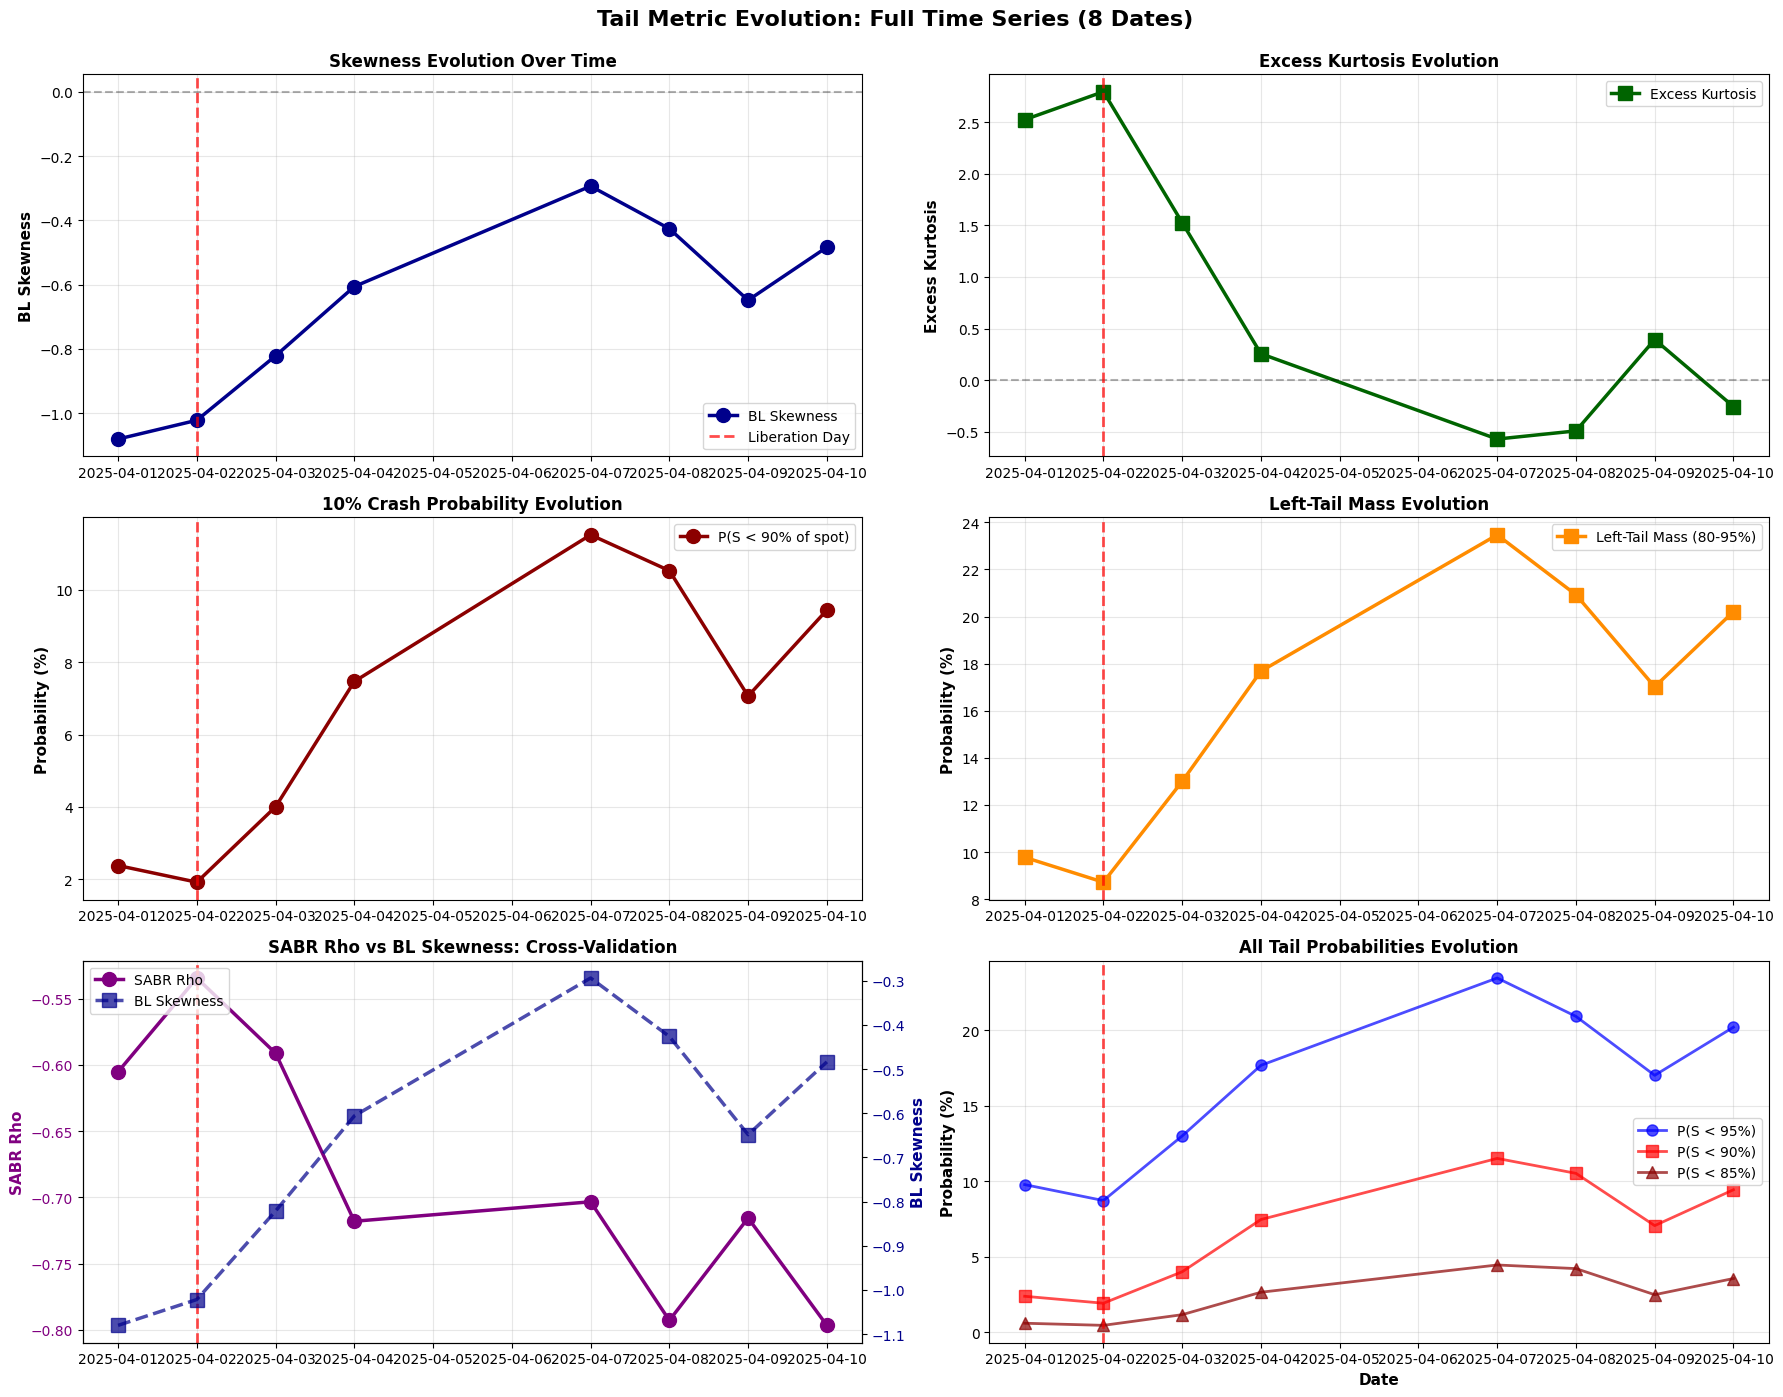

In [14]:
# Create time series plots
lib_day = pd.to_datetime('2025-04-02')
export_df['date'] = pd.to_datetime(export_df['date'])

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# Panel 1: Skewness Evolution
ax1 = axes[0, 0]
ax1.plot(export_df['date'], export_df['bl_skewness'], 'o-', linewidth=2.5, markersize=10,
         color='darkblue', label='BL Skewness')
ax1.axhline(0, color='black', linestyle='--', alpha=0.3)
ax1.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Liberation Day')
ax1.set_ylabel('BL Skewness', fontsize=11, fontweight='bold')
ax1.set_title('Skewness Evolution Over Time', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Panel 2: Excess Kurtosis Evolution
ax2 = axes[0, 1]
ax2.plot(export_df['date'], export_df['bl_excess_kurtosis'], 's-', linewidth=2.5, markersize=10,
         color='darkgreen', label='Excess Kurtosis')
ax2.axhline(0, color='black', linestyle='--', alpha=0.3)
ax2.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Excess Kurtosis', fontsize=11, fontweight='bold')
ax2.set_title('Excess Kurtosis Evolution', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel 3: P(S < 0.90S₀) Evolution
ax3 = axes[1, 0]
ax3.plot(export_df['date'], export_df['prob_s_lt_090']*100, 'o-', linewidth=2.5, markersize=10,
         color='darkred', label='P(S < 90% of spot)')
ax3.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax3.set_ylabel('Probability (%)', fontsize=11, fontweight='bold')
ax3.set_title('10% Crash Probability Evolution', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Panel 4: Left-Tail Mass Evolution
ax4 = axes[1, 1]
ax4.plot(export_df['date'], export_df['left_tail_mass']*100, 's-', linewidth=2.5, markersize=10,
         color='darkorange', label='Left-Tail Mass (80-95%)')
ax4.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_ylabel('Probability (%)', fontsize=11, fontweight='bold')
ax4.set_title('Left-Tail Mass Evolution', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# Panel 5: SABR Rho vs BL Skewness
ax5 = axes[2, 0]
ax5_twin = ax5.twinx()
line1 = ax5.plot(export_df['date'], export_df['sabr_rho'], 'o-', linewidth=2.5, markersize=10,
                 color='purple', label='SABR Rho')
line2 = ax5_twin.plot(export_df['date'], export_df['bl_skewness'], 's--', linewidth=2.5, markersize=10,
                      color='darkblue', label='BL Skewness', alpha=0.7)
ax5.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax5.set_ylabel('SABR Rho', fontsize=11, fontweight='bold', color='purple')
ax5_twin.set_ylabel('BL Skewness', fontsize=11, fontweight='bold', color='darkblue')
ax5.set_title('SABR Rho vs BL Skewness: Cross-Validation', fontsize=12, fontweight='bold')
ax5.tick_params(axis='y', labelcolor='purple')
ax5_twin.tick_params(axis='y', labelcolor='darkblue')
ax5.grid(True, alpha=0.3)
# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax5.legend(lines, labels, loc='upper left', fontsize=10)

# Panel 6: All Tail Probabilities
ax6 = axes[2, 1]
ax6.plot(export_df['date'], export_df['prob_s_lt_095']*100, 'o-', linewidth=2, markersize=8,
         color='blue', label='P(S < 95%)', alpha=0.7)
ax6.plot(export_df['date'], export_df['prob_s_lt_090']*100, 's-', linewidth=2, markersize=8,
         color='red', label='P(S < 90%)', alpha=0.7)
ax6.plot(export_df['date'], export_df['prob_s_lt_085']*100, '^-', linewidth=2, markersize=8,
         color='darkred', label='P(S < 85%)', alpha=0.7)
ax6.axvline(lib_day, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax6.set_ylabel('Probability (%)', fontsize=11, fontweight='bold')
ax6.set_xlabel('Date', fontsize=11, fontweight='bold')
ax6.set_title('All Tail Probabilities Evolution', fontsize=12, fontweight='bold')
ax6.legend(fontsize=10)
ax6.grid(True, alpha=0.3)

plt.suptitle('Tail Metric Evolution: Full Time Series (8 Dates)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('bl_time_series_evolution.png', dpi=150, bbox_inches='tight')
print("✓ Saved: bl_time_series_evolution.png")
plt.show()